In [3]:
import tensorflow as tf

from tensorflow.keras import layers, regularizers

print(tf.__version__)

2022-11-25 16:02:22.606930: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-25 16:02:22.606944: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.8.0-rc1


In [4]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [5]:
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import pathlib 
import shutil
import tempfile

In [6]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

# The Higgs dataset
It contains 11,000,000 examples, each with 28 features, and a binary class label

In [7]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

In [8]:
FEATURES = 28

The `tf.data.experimental.CsvDataset` class can be used to read csv records directly from a gzip file with no intermediate decompression step.

In [9]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

2022-11-25 16:02:32.742201: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-25 16:02:32.742234: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-25 16:02:32.742259: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nsl54): /proc/driver/nvidia/version does not exist
2022-11-25 16:02:32.742676: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


That csv reader class returns a list of scalars for each record. The following function repacks that list of scalars into a (feature_vector, label) pair.

In [10]:
def pack_row(*row):
    label = row[0]
    features = tf.stack(row[1:],1)
    return features, label

Instead of repacking each row individually make a new `tf.data.Dataset` that takes batches of 10,000 examples, applies the pack_row function to each batch, and then splits the batches back up into individual records.

In [11]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


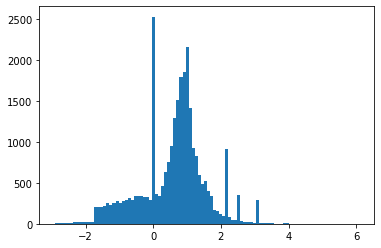

In [18]:
for features, label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(), bins=100)

In [19]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

The `Dataset.skip` and `Dataset.take` methods make this easy.

At the same time, use the `Dataset.cache` method to ensure that the loader doesn't need to re-read the data from the file on each epoch.

In [20]:
validation_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [21]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

# Overfitting
## Training

In [22]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(0.001,
                                                            decay_steps=STEPS_PER_EPOCH*1000,
                                                            decay_rate=1,
                                                            staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

The code above sets a `tf.keras.optimizers.schedules.InverseTimeDecay` to hyperbolically decrease the learning rate to 1/2 of the base rate at 1,000 epochs, 1/3 at 2,000 epochs, and so on.

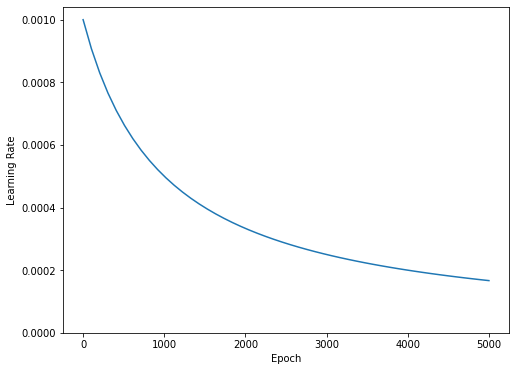

In [23]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize=(8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel("Learning Rate")

To reduce the logging noise use the tfdocs.EpochDots which simply prints a . for each epoch, and a full set of metrics every 100 epochs. Include `tf.keras.callbacks.EarlyStopping` to avoid long and unnecessary training times. Note that this callback is set to monitor the `val_binary_crossentropy`, not the `val_loss`. This difference will be important later. Use `callbacks.TensorBoard` to generate TensorBoard logs for the training.

In [24]:
def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
        tf.keras.callbacks.TensorBoard(logdir/name),
    ]

Similarly each model will use the same `Model.compile` and `Model.fit` settings.

In [37]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer,
                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                 metrics=[
                     tf.keras.losses.BinaryCrossentropy(from_logits=True,name='binary_crossentropy'),
                     'accuracy'
                 ])
    
    model.summary()
    
    history = model.fit(train_ds,
                       steps_per_epoch=STEPS_PER_EPOCH,
                       epochs=max_epochs,
                       validation_data=validation_ds,
                       callbacks=get_callbacks(name),
                       verbose=0)
    return history

## Tiny model

In [38]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [39]:
size_histories = {}


In [40]:
size_histories['Tiny'] =  compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 16)                464       
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


ValueError: in user code:

    File "/home/nsl54/anaconda3/envs/mlenv/lib/python3.7/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/home/nsl54/anaconda3/envs/mlenv/lib/python3.7/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/nsl54/anaconda3/envs/mlenv/lib/python3.7/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/home/nsl54/anaconda3/envs/mlenv/lib/python3.7/site-packages/keras/engine/training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "/home/nsl54/anaconda3/envs/mlenv/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/nsl54/anaconda3/envs/mlenv/lib/python3.7/site-packages/keras/engine/input_spec.py", line 228, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential_3" (type Sequential).
    
    Input 0 of layer "dense_6" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (28,)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(28,), dtype=float32)
      • training=True
      • mask=None


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ValueError: max() arg is an empty sequence

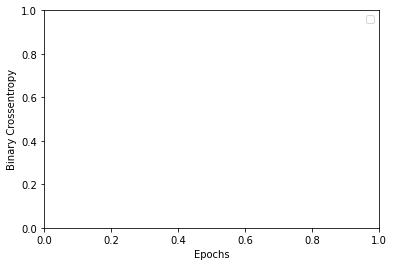

In [41]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])